In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import interpolation as ipt
from scipy.ndimage import map_coordinates
import skimage.transform as transform

In [2]:
df = pd.DataFrame.from_dict({
    'file name': [
        'agc4109natural_kmh20kms.edit4_mom0.fits',
        '9244_CLN_V2_0.edit3_mom0.fits',
        'agc6871all_natural_kmh20kms.edit3smo_mom0.fits',
        '9362_CLN_V2_4.edit1_mom0.fits',
        '8408_CLN_V2_0.edit1_mom0.fits',
        'B10_ALL_NAT.APCLN.edit6_mom0.fits',
    ],
    'rotation': [i for i in [82.83, 39.01, 33.74, 64.5, -37.45, 40.42]],
    'pixel size': [1.7, 2, 1.4, 2, 2, 1.7],
    'bar length': [15.0, 15.8, 13.4, 18.2, 10.4, 9.6],
    'beam major': [8.93745, 7.7544, 5.89444, 7.28172, 9.61848, 10.8678],
    'beam minor': [5.09657, 5.27256, 4.7826, 4.8024, 4.7592, 5.08985],
    'beam pa': [-56.1455, 69.09, -32.4369, 62.98, 80.73, -56.165],
    'ra': [119.0693, 216.53495, 178.44321, 218.32296, 200.7516, 185.00551],
    'dec': [11.66217, 5.23793, 10.40315, 3.9034, 13.95065, 8.60778],
})
df

,file name,rotation,pixel size,bar length,beam major,beam minor,beam pa,ra,dec
0,agc4109natural_kmh20kms.edit4_mom0.fits,82.83,1.7,15.0,8.93745,5.09657,-56.1455,119.06930,11.66217
1,9244_CLN_V2_0.edit3_mom0.fits,39.01,2.0,15.8,7.75440,5.27256,69.0900,216.53495,5.23793
2,agc6871all_natural_kmh20kms.edit3smo_mom0.fits,33.74,1.4,13.4,5.89444,4.78260,-32.4369,178.44321,10.40315
3,9362_CLN_V2_4.edit1_mom0.fits,64.50,2.0,18.2,7.28172,4.80240,62.9800,218.32296,3.90340
4,8408_CLN_V2_0.edit1_mom0.fits,-37.45,2.0,10.4,9.61848,4.75920,80.7300,200.75160,13.95065
5,B10_ALL_NAT.APCLN.edit6_mom0.fits,40.42,1.7,9.6,10.86780,5.08985,-56.1650,185.00551,8.60778


In [3]:
matplotlib.rcParams.update({'font.size': 8})

In [8]:
hIFits = fits.open(df['file name'][0])
data = hIFits[0].data

extent = np.repeat(np.array(data.shape) * df['pixel size'][0] / 2, 2) * [-1, 1, -1, 1]

In [9]:
# Create a WCS object
w = WCS(df['file name'][0], naxis=2)

center = w.all_world2pix([[df['ra'][0], df['dec'][0]]], 0)[0]

# Find the offset of the center point of the galaxy from that of the image in pixel coordinates
offset = center - np.array(data.shape) / 2
print(offset)

[-1.14066641  6.94824061]


[-1.9391329  11.81200903]


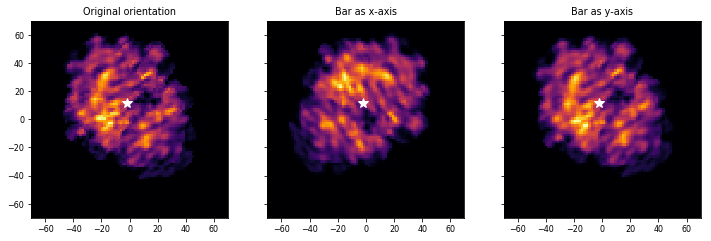

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=3, sharey=True)

ax0.set_title('Original orientation')
ax0.imshow(data, origin='lower', cmap='inferno', extent=tuple(extent))

# rotate around galaxy center to bar
data_rotated = transform.rotate(data, df['rotation'][0], center=center)
ax1.set_title('Bar as x-axis')

ax1.imshow(data_rotated, origin='lower', cmap='inferno', extent=tuple(extent))

# rotate to perp
ax2.set_title('Bar as y-axis')
data_rotated_perp = transform.rotate(data, df['rotation'][0] - 90, center=center)
ax2.imshow(data_rotated_perp, origin='lower', cmap='inferno', extent=tuple(extent))

print((center - np.array(data.shape) / 2) * df['pixel size'][0])
for ax in (ax0, ax1, ax2):
    ax.set_xlim(-70, 70)
    ax.set_ylim(-70, 70)
    ax.plot(*(center - np.array(data.shape) / 2) * df['pixel size'][0], 'w*', markersize=10)

In [7]:
X, Y = np.mgrid[
    0:data_rotated.shape[0]:data_rotated.shape[0]*1j,
    center[1]-1:center[1]+1:6j
]
positions = np.vstack([X.ravel(), Y.ravel()])
cross_section = map_coordinates(data_rotated, positions, order=1).reshape(-1, 6).mean(axis=1)

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.imshow(data_rotated, origin='lower', cmap='inferno', extent=extent)
plt.plot(*((positions.T - np.array(data.shape) / 2)*df['pixel size'][0]).T, '.')
plt.xlim(-70, 70)
plt.ylim(-70, 70)
plt.subplot(122)
plt.plot(
    np.linspace(extent[0], extent[1], 512),
    cross_section,
)
plt.xlim(-70, 70)

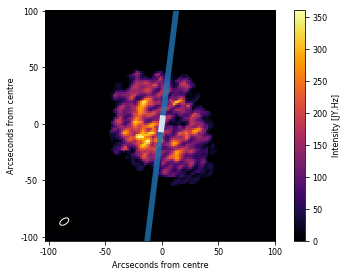

In [20]:
galaxy = makeGalaxyObject(df.iloc[0])
m = 60
shouldShowBar = True
ticksize = 50
beamPosition = [10, 10]

n = m * 1.7 / galaxy['pixel size']
lowerCrop = (galaxy['center'] - n).astype(int)
upperCrop = (galaxy['center'] + n).astype(int)

rotatedLowerCrop = (galaxy['rotatedCenter'] - n).astype(int)
rotatedUpperCrop = (galaxy['rotatedCenter'] + n).astype(int)

fig = plt.figure()
ax = plt.gca()

# show the HI data
im = plt.imshow(
    galaxy['hIFits'][0].data,
    origin='lower',
    cmap='inferno'
)

# Add rectangles to represent center region and bar size, in the correct orientation
if shouldShowBar:
    list(map(ax.add_artist, genBarRectangle(galaxy, galaxy['rotation matrix'])))

# add the beam
ax.add_artist(
    genBeamEllipse(galaxy, center=lowerCrop + beamPosition)
)

# Choose the x-ticks we want to display (every 50 arcseconds)
xticks = np.arange(-500, 500, ticksize)
# figure out where they should be positioned and place them
ax.set_xticks(xticks / galaxy['pixel size'] + galaxy['center'][0])
# set the labels
ax.set_xticklabels(xticks)

# same as above for y-axis
yticks = np.arange(-500, 500, ticksize)
ax.set_yticks(yticks / galaxy['pixel size'] + galaxy['center'][1])
ax.set_yticklabels(yticks)

# axis labels
ax.set_xlabel('Arcseconds from centre')
ax.set_ylabel('Arcseconds from centre')

# setting limits to crop our image
ax.set_xlim(lowerCrop[0], upperCrop[0])
ax.set_ylim(lowerCrop[1], upperCrop[1])

# adjust the positioning so we can fit the colorbar in
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.5)

# add the colorbar axes
cbar = plt.colorbar()
cbar.set_label('Intensity [JY.Hz]')